In [1]:
#Run this cell before the other stuff
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
players <- read_csv("https://raw.githubusercontent.com/nothingbutash/dsci-100-2024w2-group-006-2/refs/heads/main/players.csv") |>
    mutate(experience = as_factor(experience))
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17


**(1)**
I chose players.csv:
- *players.csv has 196 observations and 7 variables. These variables include:*
    1. experience: character (but should be factor) noting player's Minecraft familiarity. Likely self-reported.
    2. subscribe: logical, true if the player subscribed to the newsletter.
    3. hashedEmail:  char, player's encoded email address.
    4. played_hours: numeric (double). Likely tracked by server.
    5. name: char, first name of player.
    6. gender: char, gender of player. Likely self-reported.
    7. Age: numeric (double), age of participant.

- *Issues:*

    1. Experience may be self-reported and thus difficult to apply quantitatively (also numerical operations won't work on it).
    2. From a cursory look in the data, there appears to be a concentration around 15 - 24. This may constitute data skew.
    3. Participants who entered their age at different enough times can have incorrect relative ages to each other. If the ages are calculated using date of birth, this should not be a problem though.

Summary statistics below.

In [3]:
subscribed_players <- players |>
    filter(subscribe == TRUE) |>
    nrow()
nonsubscribed_players <- players |>
    filter(subscribe == FALSE) |>
    nrow()
print(paste0(subscribed_players, " players out of 196 are subscribed, aka ", subscribed_players/196*100, " percent."))


[1] "144 players out of 196 are subscribed, aka 73.469387755102 percent."


In [4]:
types_count <- players |>
    group_by(experience) |>
    summarize(num = n())
types_count
#The above is a table of the number of players belonging to each type
percent_types <- types_count |>
    mutate(percent_of_sample = num/196*100) |>
    select(experience, percent_of_sample)
percent_types
#The above is a table of the percentage of the sample each player type represents (out of 196 total)
#I selected for experience and num to make it more clear without irrelevant data getting in the way

experience,num
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


experience,percent_of_sample
<fct>,<dbl>
Pro,7.142857
Veteran,24.489796
Amateur,32.142857
Regular,18.367347
Beginner,17.857143


The above statistics show the composition of the dataset, in terms of those subscribed and of different experiences listed.

**(2)**
The broad question I want to address is Question 1. My specific question is "Can age, self-reported experience, and/or playtime on the server predict whether a player signs up for the newsletter?"

I will answer the question by saying which, if any of the variables, can. The data will help me by providing a large sample with a diverse spread of values. I will wrangle it by turning experience to factor.

**(3)**
Above (at [25]) I loaded and wrangled the dataset. The data appears tidy (one observation per row, value per cell, and variable per column).

The table of mean values is below:

In [5]:
#It was a fairly simple process to get a table of the numeric variable's mean values, as I applied the process learned in class
mean_table <- players |>
    select(played_hours,Age) |>
    map_df(mean, na.rm = TRUE)
# noticed that there's at least one NA value in Age (???) so I had to remove them
mean_table

played_hours,Age
<dbl>,<dbl>
5.845918,20.52062


New names:
• `experience` -> `experience...1`
• `num` -> `num...2`
• `experience` -> `experience...3`
• `num` -> `num...4`


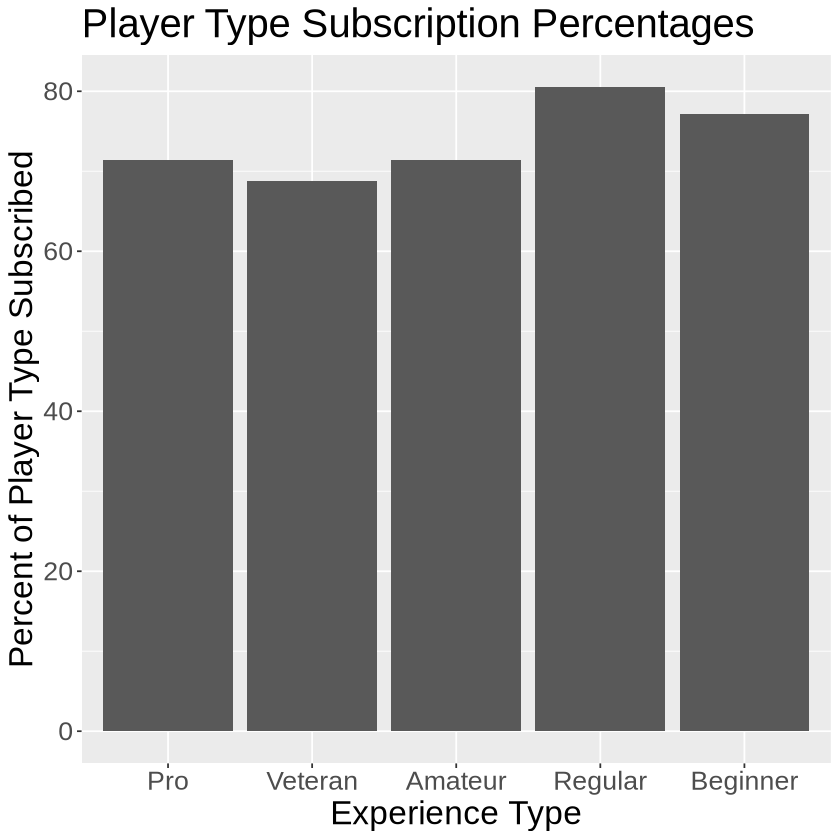

In [6]:
#In this table, I recorded the amount of subscribed players within each type.
subscribed_types_count <- players |>
    filter(subscribe == TRUE) |>
    group_by(experience) |>
    summarize(num = n())

#To account for differing amounts of each type, I used the below process to return subscription percentages for each player type
subscription_by_type_percentages <- subscribed_types_count |>
    bind_cols(types_count) |>
    mutate(percent_sub = num...2 / num...4 * 100) |>
    mutate(experience = experience...1) |>
    select(experience, percent_sub)

#Finally, I used the data from above to make a visualization comparing subscription rates across player types.
subscription_by_type_plot <- subscription_by_type_percentages |>
    ggplot(aes(x = experience, y = percent_sub)) +
    geom_bar(stat = "identity") +
    labs(x = "Experience Type", y = "Percent of Player Type Subscribed", title = "Player Type Subscription Percentages") +
    theme(text = element_text(size = 20))
subscription_by_type_plot

The subscription percentages appear to be quite similar. This may not be a good predictor (or be problematic to analyze). However, prior to further predictive analysis this is unproven.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


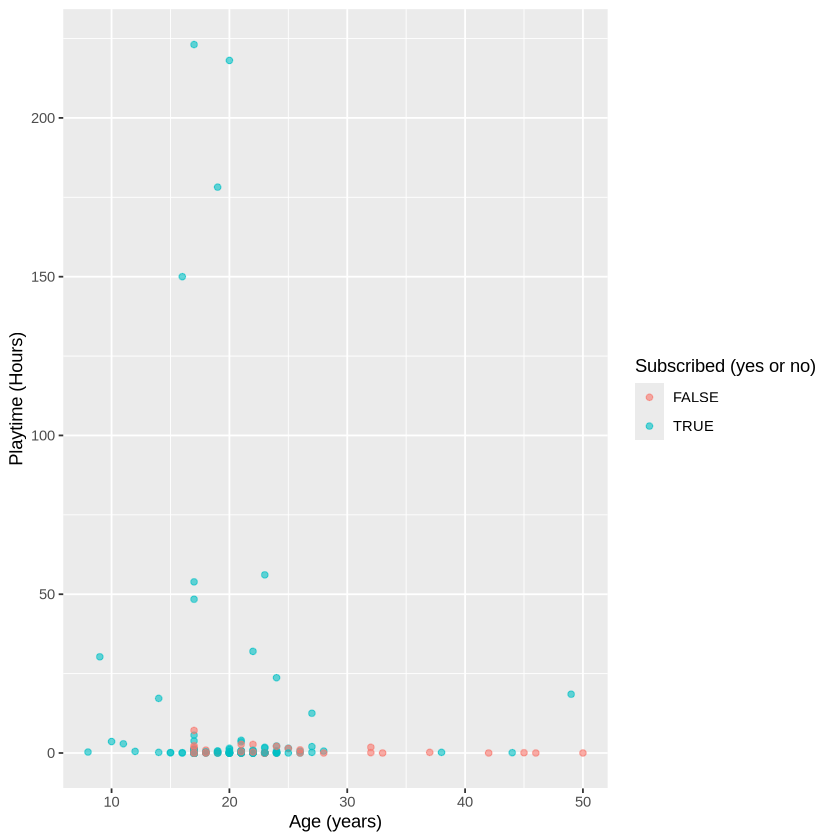

In [7]:
#For this visualization, I plan to plot age against playtime, with colour denoting subscription status (similar to the cancer classification example from class)
playtime_age_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (years)", y = "Playtime (Hours)", color = "Subscribed (yes or no)")

playtime_age_plot

It appears most players have playtimes below 10 hours, and anyone above that is subscribed, which is intriguing. Additionally, higher playtimes are more common among younger people (age > 30), emphasizing the importance of scaling and centering the data.

**(4)**
I plan to determine if my variables are individually good predictors of subscription then use the good ones together in a model. I will use k-nearest neighbours classification since it's versatile and I'm predicting a non-numeric variable.


I will split 75% of the data for training. Then I will cross-validate using a V of 5, and find the most accurate k value from 1 to 196. I will find the tested accuracy of the optimal k then see if it's good.

A variable will be a good predictor with a testing accuracy above 55% (the model performs better than random guessing, give or take the standard 5% uncertainty). I want the same or better for my conjunction model.

This model will use knn, so I'll be sure to scale and center the data. I am assuming that the data (both self-reported and virtually recorded) is accurate, and that the sample is representative enough.
